In [94]:
from sklearn.datasets import fetch_openml
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt
import numpy as np

from normflows import config, nn_models, transformations, distributions

%matplotlib inline

In [63]:
phi = np.load((config.models / 'mnist' / 'weights_phi.npy').open('rb'))
theta = np.load((config.models / 'mnist' / 'weights_theta.npy').open('rb'))

In [64]:
phi

array([-0.05499903, -0.02672175,  0.0129498 , ..., -0.08513352,
        0.04225834, -0.12999023])

In [65]:
theta

array([ 0.04992065,  0.12253905, -0.13990146, ..., -0.15711209,
       -0.10088887, -0.14796187])

In [71]:
K = 3
dim_z = 2
dim_x = 28 * 28
width = 64
n_hidden = 3
activation_fn = transformations.relu

encoder_architecture = {
    'width': width,
    'hidden_layers': n_hidden,
    'input_dim': dim_x,
    'output_dim': 2 * dim_z + 2 * dim_z * K + 1 * K,
    'activation_fn_type': 'tanh',
    'activation_fn_params': '',
    'activation_fn': activation_fn
}
decoder_architecture = {
    'width': width,
    'hidden_layers': n_hidden,
    'input_dim': dim_z,
    'output_dim': dim_x,
    'activation_fn_type': 'tanh',
    'activation_fn_params': '',
    'activation_fn': activation_fn,
    'output_activation_fn': transformations.sigmoid
}

encoder = nn_models.Feedforward(architecture=encoder_architecture)
decoder = nn_models.Feedforward(architecture=decoder_architecture)

In [72]:
def sample_from_prior_z(i, j):
    grid_dims = np.random.randn(2) + np.array([i, j])
#     res = np.insert(np.zeros(dim_z - 2), 0, grid_dims)
    return grid_dims

def decode(z):
    logits = decoder.forward(theta.reshape(1, -1), z.reshape(-1, 1)).T
    xhat = np.random.binomial(1, logits)
    im_recon = xhat.reshape(28, 28)
    return im_recon

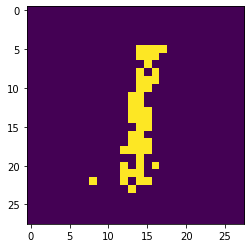

In [73]:
z = sample_from_prior_z(-4, -4)
im_recon = decode(z)
plt.imshow(im_recon)

In [76]:
xmin, xmax = -20, 20
ymin, ymax = -20, 20
all_ims = np.zeros((28 * (xmax - xmin), 28 * (ymax - ymin)))
for i in np.arange(xmin, xmax):
    for j in np.arange(ymin, ymax):
        z = sample_from_prior_z(i, j)
        im_recon = decode(z)
        row = i - xmin
        col = j - ymin
        all_ims[28 * row:28 * (row + 1), 28 * col:28 * (col + 1)] = im_recon

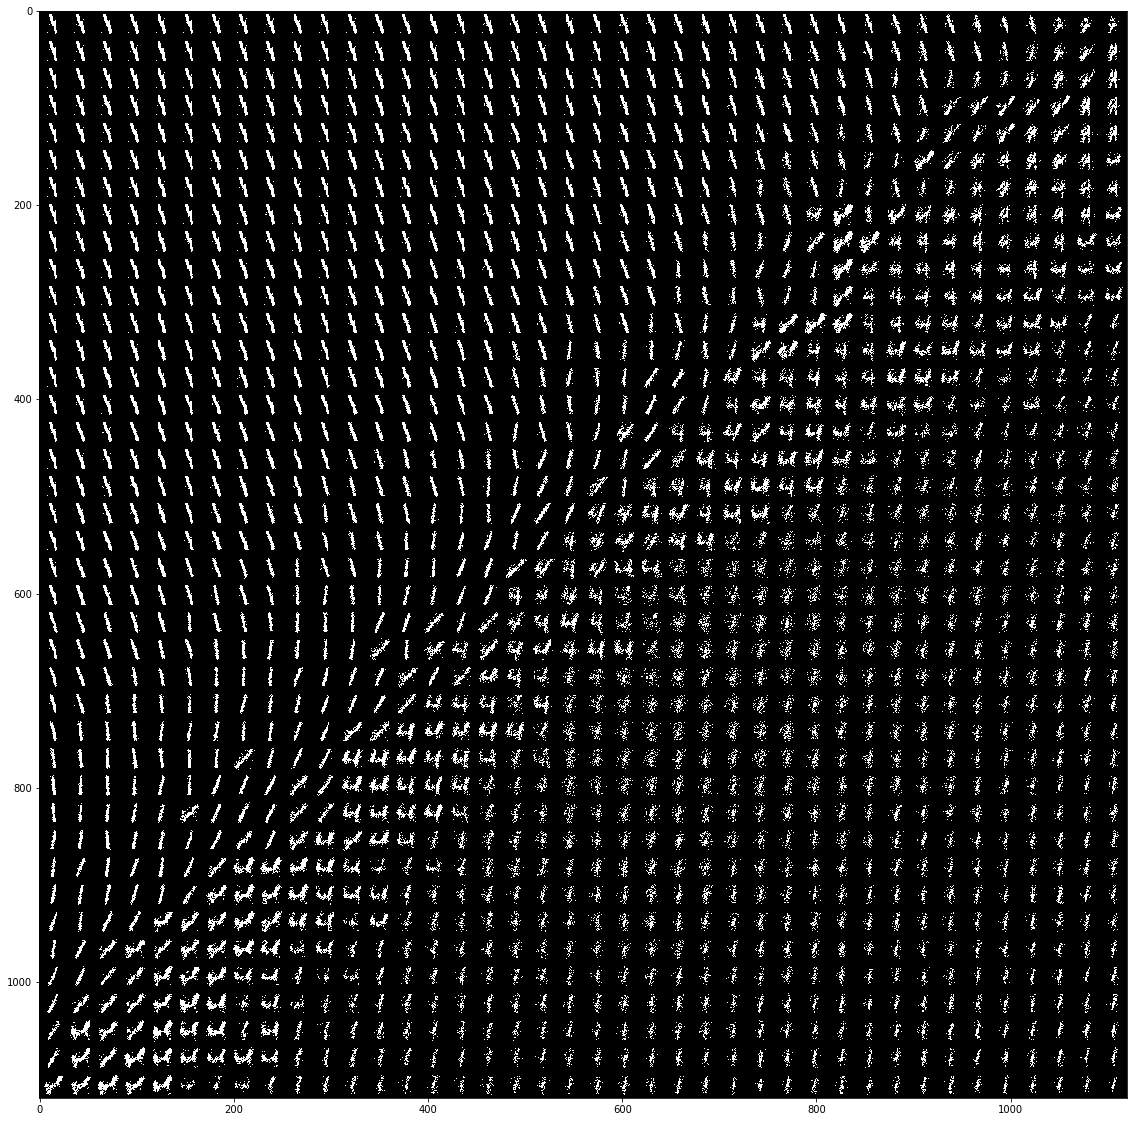

In [77]:
plt.figure(figsize=(20, 20))
plt.imshow(all_ims, cmap='gray')

In [78]:
def load_data():
    X, y = loadlocal_mnist(
        images_path=str(config.mnist / 'train-images-idx3-ubyte'),
        labels_path=str(config.mnist / 'train-labels-idx1-ubyte'))

    keep_digits = np.isin(y, [1, 4])
    X = X[keep_digits]
    y = y[keep_digits]
    X = X / 255
    X = (X >= 0.5).astype(int)  # Binarizing
    return X, y

X, y = load_data()

In [91]:
X1 = X[y == 1]
X4 = X[y == 4]

sample_1 = X1[np.random.choice(np.arange(X1.shape[0]))].reshape(28, 28)
sample_4 = X4[np.random.choice(np.arange(X4.shape[0]))].reshape(28, 28)

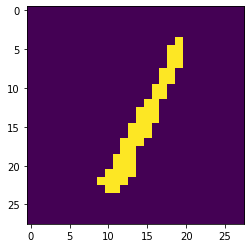

In [93]:
plt.imshow(sample_1)

In [115]:
def encode(weights, X, n_samples=100):
    N = X.shape[0]
    phi = encoder.forward(weights.reshape(1, -1), X.T)[0]
    mu0 = phi[:dim_z].reshape(N, dim_z)
    log_sigma_diag0 = phi[dim_z:2 * dim_z].reshape(N, dim_z)
    W = phi[2 * dim_z:2 * dim_z + K * dim_z].reshape(K, N, dim_z)
    U = phi[2 * dim_z + K * dim_z:2 * dim_z + 2 * K * dim_z].reshape(K, N, dim_z)
    b = phi[-K:].reshape(K, N)
    samples = []
    for _ in range(n_samples):
        samples.append(distributions.sample_from_pz(mu0, log_sigma_diag0, W, U, b, K))
    return np.vstack(samples)

In [134]:
z1 = encode(phi, sample_1.reshape(1, -1), n_samples=5000)
z4 = encode(phi, sample_4.reshape(1, -1), n_samples=5000)

TypeError: _vhstack_dispatcher() takes 1 positional argument but 2 were given

In [135]:
z = np.vstack((z1, z4))
z.shape

(10000, 2)

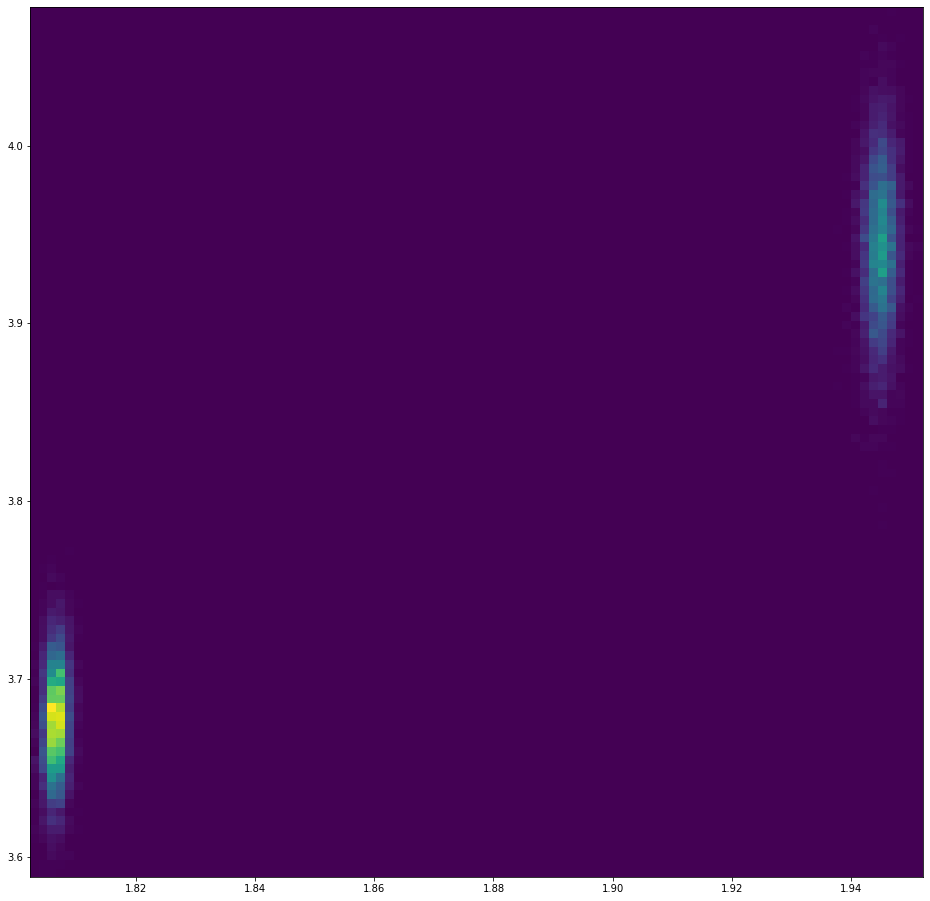

In [139]:
plt.figure(figsize=(16, 16))
# plt.hist2d(z1[:, 0], z1[:, 1], bins=100)
# plt.hist2d(z4[:, 0], z4[:, 1], bins=100)
plt.hist2d(z[:, 0], z[:, 1], bins=100)
plt.show()

In [141]:
def get_latent_params(weights, X):
    N = X.shape[0]
    phi = encoder.forward(weights.reshape(1, -1), X.T)[0]
    mu0 = phi[:dim_z].reshape(N, dim_z)
    log_sigma_diag0 = phi[dim_z:2 * dim_z].reshape(N, dim_z)
    W = phi[2 * dim_z:2 * dim_z + K * dim_z].reshape(K, N, dim_z)
    U = phi[2 * dim_z + K * dim_z:2 * dim_z + 2 * K * dim_z].reshape(K, N, dim_z)
    b = phi[-K:].reshape(K, N)
    return mu0, log_sigma_diag0, W, U, b

In [144]:
mu01, log_sigma_diag01, W1, U1, b1 = get_latent_params(phi, sample_1.reshape(1, -1))

In [145]:
W1

array([[[-0.54370359, -2.74893464]],

       [[-0.28859837,  3.18950134]],

       [[-0.21949712,  4.13059563]]])

In [146]:
U1

array([[[-1.43879456,  0.0704458 ]],

       [[-0.0031515 , -0.02056899]],

       [[ 0.81160974,  0.77776871]]])